# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [71]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, GraphPlot
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, SimpleWeightedGraphs, Compose
include("FYON_2022_STG_kinetics.jl") # Loading of DA kinetics of gating variables
include("FYON_2022_STG_models.jl") # Loading of DA model
include("FYON_2022_STG_utils.jl") # Loading of some utils functions
include("FYON_2022_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("FYON_2022_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("FYON_2022_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 5000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const C     = 1. # Membrane capacitance
const VNa   = 50 # Sodium reversal potential
const VK    = -80 # Potassium reversal potential
const VCa   = 80 # Calcium reversal potential
const VH    = -20 # HCN channels reversal potential
const Vleak = -50 # Leak reversal potential

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

struct eig
           values
           vectors
       end

default(fmt = :png);

In [3]:
# Defining colors
myCompleteBlue = RGB{Float64}(0. / 255., 125. / 255., 197. / 255.)
myDICBlue = RGB{Float64}(0. / 255., 119. / 255., 182. / 255.)
myLeakBlue = RGB{Float64}(131. / 255., 174. / 255., 218. / 255.);

# **Computing pairwise correlations of high frequency bursting neurons using Monte Carlo dataset (Figure 1)**

In [4]:
# Initializing some variables
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02
N = 7e4
VV_maxmax = 49.95
VV_maxmin = 49.9
VV_minmax = -69.
VV_minmin = -76.
nb_spikes_target = 5
burstiness_min = 3000.
burstiness_max = 7000.
interburst_f_min = 8.8
interburst_f_max = 9.9
intraburst_f_max = 140.
intraburst_f_min = 70.
nb_channels = 8

g_all_MC = readdlm("./data/g_all_MC.dat")

names = [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
         L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
         L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]
maxs = [Na_max, CaT_max, CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max];

3×3 Matrix{Float64}:
  0.590312   NaN         NaN
 -0.0500555   -0.383654  NaN
  0.608978     0.293368    0.0114151

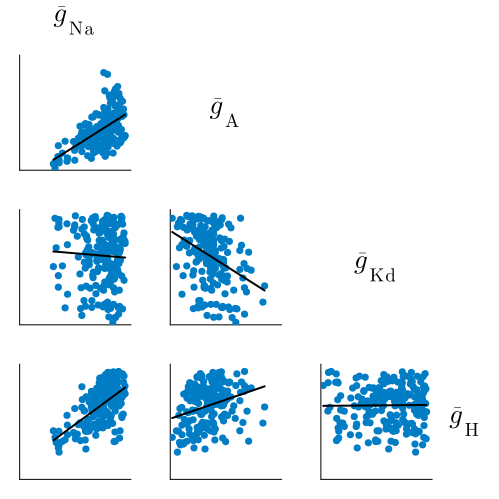

In [5]:
indices = [1, 4, 6, 7]
p1a = scatter_matrix3x3(g_all_MC[:, indices], maxs[indices], myCompleteBlue, :none, names[indices], flag=0)
display(p1a)
# savefig(p1a, "./figures/STG_MC_matrix3x3_corr.pdf")

In [6]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_MC[:, i1], g_all_MC[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end

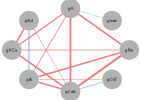

In [7]:
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gCaT", "gCaS", "gA", "gKCa", "gKd", "gH", "gleak"]

p1b = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(p1b)
# draw(SVG("./figures/STG_graph_corr.svg", 16cm, 16cm), p1b);

In [8]:
# Initializing some variables
Rin_bursting_MC = zeros(ncells)
V_Rin = -60.

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : ncells
    Ca_th = -0.94*(g_all_MC[i, 2]*mCaT_inf(V_Rin)^3*hCaT_inf(V_Rin)*(V_Rin-VCa) + 
                   g_all_MC[i, 3]*mCaS_inf(V_Rin)^3*hCaS_inf(V_Rin)*(V_Rin-VCa)) + 0.05
    Rin_bursting_MC[i] = (g_all_MC[i, 1]*mNa_inf(V_Rin)^3*hNa_inf(V_Rin) + 
                            g_all_MC[i, 2]*mCaT_inf(V_Rin)^3*hCaT_inf(V_Rin) + 
                            g_all_MC[i, 3]*mCaS_inf(V_Rin)^3*hCaS_inf(V_Rin) + 
                            g_all_MC[i, 4]*mA_inf(V_Rin)^3*hA_inf(V_Rin) +
                            g_all_MC[i, 5]*mKCa_inf(V_Rin, Ca_th)^4 +
                            g_all_MC[i, 6]*mKd_inf(V_Rin)^4 +
                            g_all_MC[i, 7]*mH_inf(V_Rin) + 
                            g_all_MC[i, 8])^(-1)
end

g_all_MC_normalized = deepcopy(g_all_MC)
for i = 1 : ncells
    g_all_MC_normalized[i, :] = g_all_MC_normalized[i, :] .* Rin_bursting_MC[i]
    #g_all_MC_normalized[i, :] = g_all_MC_normalized[i, :] ./ g_all_MC[i, end]
end

3×3 Matrix{Float64}:
  0.650489  NaN         NaN
 -0.276913   -0.451809  NaN
  0.414768    0.124476   -0.258135

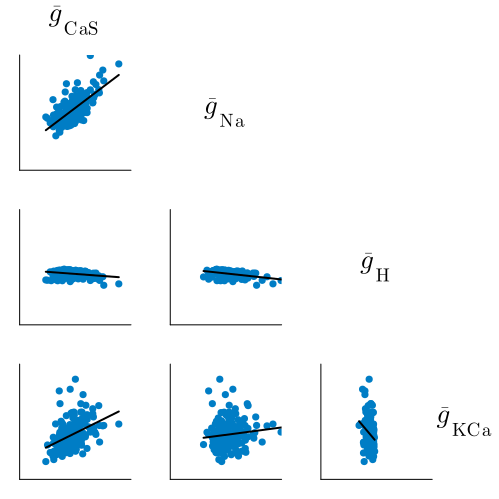

In [9]:
indices = [3, 1, 7, 5]
p4c = scatter_matrix3x3(g_all_MC_normalized[:, indices], maxs[indices]*17, 
                        myCompleteBlue, :none, 
                        names[indices], flag=0)
display(p4c)
# savefig(p4b, "./figures/DA_spiking_norm_matrix3x3_PC12.pdf")

# **Computing PCA of high frequency bursting neurons using Monte Carlo dataset (Figure 2)**

In [10]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC[:, i] / std(g_all_MC[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] * std(g_all_MC[:, i])
end

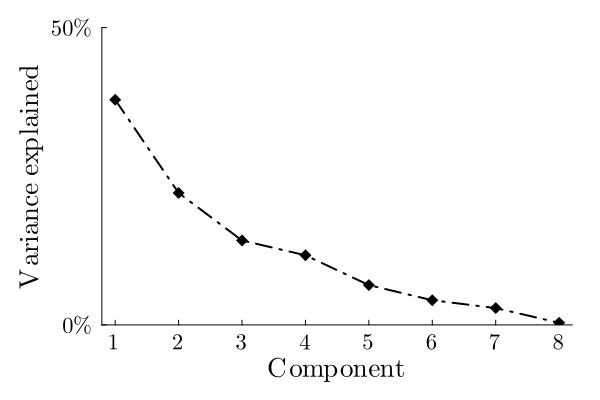

In [11]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values) ./ total_var

p2a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 0.5], [L"0\%", L"50\%"]), size=(600, 400))

ylims!((0., 0.5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p2a)
# savefig(p2a, "./figures/STG_MC_scree.pdf")

In [12]:
important_PCA = 0

expl_var = 0.
while(expl_var < 0.8)
    important_PCA = important_PCA + 1
    expl_var = expl_var + eig_val_decreasing[important_PCA]
end
display(important_PCA)

4

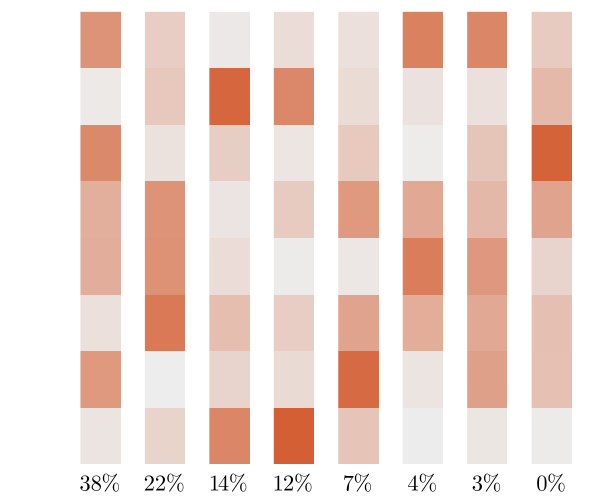

In [13]:
p2b = heatmap_dir(eig_MC, nb_channels)
display(p2b)
# savefig(p2b, "./figures/STG_MC_eig_vectors.pdf")

# **Comparing PC1 of high frequency bursting neurons using Monte Carlo dataset to homogeneous scaling (Figure 3)**

In [63]:
PC1_abs = abs.(eig_MC.vectors[:, nb_channels]) ./ 
        norm(eig_MC.vectors[:, nb_channels])
best_four = sortperm(PC1_abs, rev=true)[1:4];

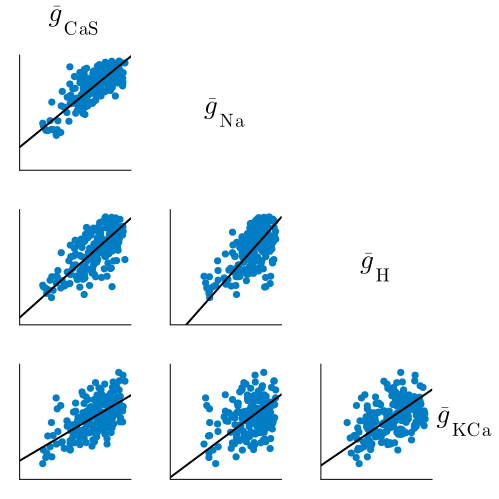

In [64]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
p3 = scatter_matrix3x3(g_all_MC[:, best_four], maxs[best_four], myCompleteBlue, :none, names[best_four], 
                  flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(p3)
# savefig(p3, "./figures/STG_MC_matrix3x3_PC1.pdf")

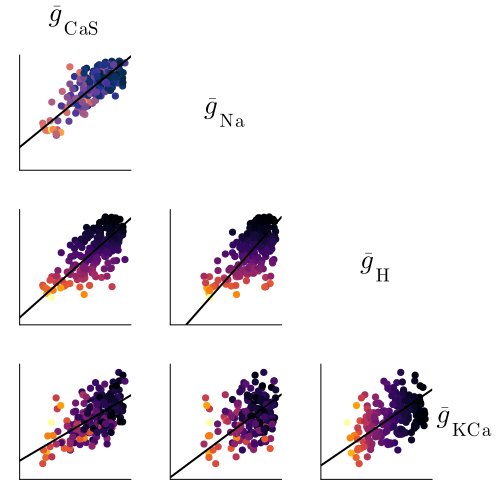

In [72]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
p3 = scatter_matrix3x3_zcolor(g_all_MC[:, best_four], maxs[best_four], Rin_bursting_MC, :none, names[best_four], 
                  flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(p3)
# savefig(p3, "./figures/STG_MC_matrix3x3_PC1.pdf")

In [16]:
function angle_between_vectors(u, v)
    dot_prod = dot(u, v)
    norm_u = norm(u)
    norm_v = norm(v)
    angle = acosd(dot_prod / (norm_u * norm_v))
    return angle
end

PC1 = -eig_MC.vectors[:, nb_channels]
homo_scaling = deepcopy(vec(mean_MC))
for i = 1 : nb_channels
    homo_scaling[i] = homo_scaling[i] / std(g_all_MC[:, i])
end

display(angle_between_vectors(PC1, homo_scaling))
display(cosd(angle_between_vectors(PC1, homo_scaling)))

37.69493741812092

0.7912775636267837

# **Interpreting other PCs of high frequency bursting neurons using custom dataset to zero sensitivity direction of slow dynamical properties of the membrane (Figure 4)**

In [17]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_doublets = readdlm("./data/g_all_doublets.dat")
g_all_doublets_DIC = readdlm("./data/g_all_doublets_DIC.dat")
g_all_doublets_leak = readdlm("./data/g_all_doublets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat");

In [18]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting)

# Normalizing data before applying PCA
g_all_bursting_norm = deepcopy(g_all_bursting)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting[:, i] / std(g_all_bursting[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] * std(g_all_bursting[:, i])
end

In [19]:
PC2_abs = abs.(eig_bursting.vectors[:, nb_channels-1]) ./ 
        norm(eig_bursting.vectors[:, nb_channels-1])
best_four = sortperm(PC2_abs, rev=true)[1:4];
best_four = [1, 4, 3, 7];

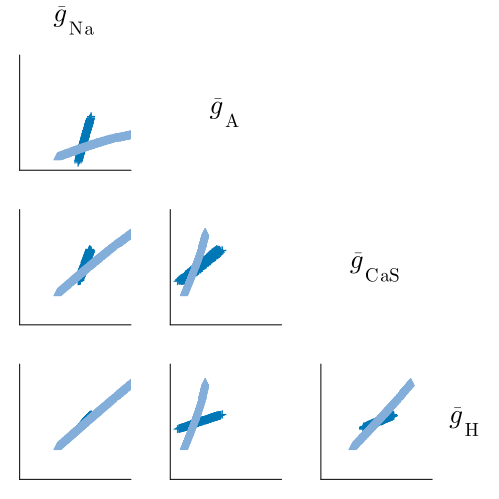

In [20]:
p4a = scatter_matrix3x3(g_all_bursting_DIC[:, best_four], maxs[best_four], myDICBlue, :cross, 
                       names[best_four], flag=3, flag2=1, g_all2=g_all_bursting_leak[:, best_four], 
                       color_p2=myLeakBlue, m_shape2=:utriangle)
display(p4a)
# savefig(p4a, "./figures/STG_bursting_matrix3x3_separated.pdf")

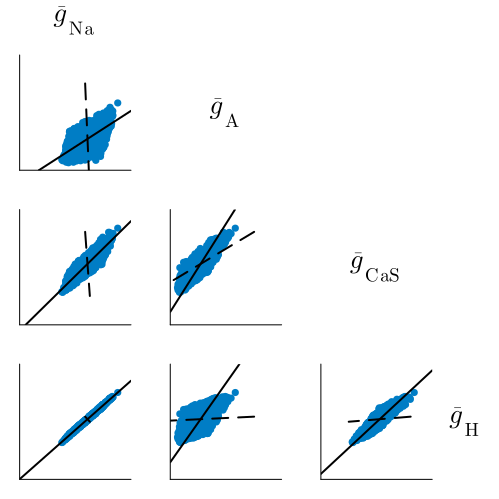

In [21]:
dir_val = eig(eig_bursting_plot.values[end],  eig_bursting_plot.vectors[best_four, :])
p4b = scatter_matrix3x3(g_all_bursting[:, best_four], maxs[best_four], myCompleteBlue, :none, names[best_four], 
                       flag=2, dir_val=dir_val, mean_vec=mean_bursting[best_four], s1=10, s2=1)
display(p4b)
# savefig(p4b, "./figures/STG_bursting_matrix3x3_PC12.pdf")

In [22]:
# Initializing some variables
Rin_bursting = zeros(500)
V_Rin = -60.

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : 500
    Ca_Rin = -0.94*(g_all_bursting[i, 2]*mCaT_inf(V_Rin)^3*hCaT_inf(V_Rin)*(V_Rin-VCa) + 
                   g_all_bursting[i, 3]*mCaS_inf(V_Rin)^3*hCaS_inf(V_Rin)*(V_Rin-VCa)) + 0.05
    Rin_bursting[i] = (g_all_bursting[i, 1]*mNa_inf(V_Rin)^3*hNa_inf(V_Rin) + 
                       g_all_bursting[i, 2]*mCaT_inf(V_Rin)^3*hCaT_inf(V_Rin) + 
                       g_all_bursting[i, 3]*mCaS_inf(V_Rin)^3*hCaS_inf(V_Rin) + 
                       g_all_bursting[i, 4]*mA_inf(V_Rin)^3*hA_inf(V_Rin) +
                       g_all_bursting[i, 5]*mKCa_inf(V_Rin, Ca_Rin)^4 +
                       g_all_bursting[i, 6]*mKd_inf(V_Rin)^4 +
                       g_all_bursting[i, 7]*mH_inf(V_Rin) + 
                       g_all_bursting[i, 8])^(-1)
end

g_all_bursting_normalized = deepcopy(g_all_bursting)
for i = 1 : 500
    g_all_bursting_normalized[i, :] = g_all_bursting_normalized[i, :] .* Rin_bursting[i]
    #g_all_bursting_normalized[i, :] = g_all_bursting_normalized[i, :] ./ g_all_bursting[i, end]
end

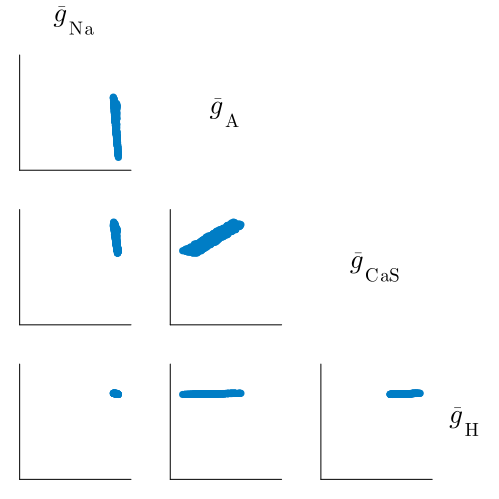

In [23]:
p4c = scatter_matrix3x3(g_all_bursting_normalized[:, best_four], maxs[best_four]*10, 
                        myCompleteBlue, :none, 
                        names[best_four], flag=3)
display(p4c)
# savefig(p4b, "./figures/STG_spiking_norm_matrix3x3_PC12.pdf")

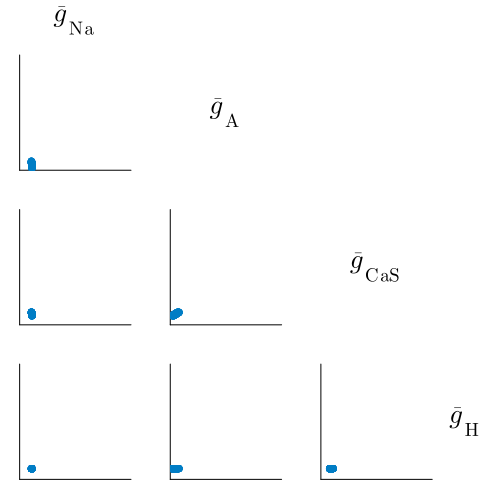

In [24]:
p4c = scatter_matrix3x3(g_all_bursting_normalized[:, best_four], maxs[best_four]*80, 
                        myCompleteBlue, :none, 
                        names[best_four], flag=3)
display(p4c)
# savefig(p4b, "./figures/STG_spiking_norm_matrix3x3_PC12.pdf")

# **Interpreting other PCs of high frequency bursting neurons using Monte Carlo dataset to zero sensitivity direction of slow dynamical properties of the membrane (Figure 5)**

In [25]:
# Extracting threshold voltage and weighting factors for a specific neuron
Random.seed!(543)
(gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_MC[Int(ceil(rand(1, 1)[1]*ncells)), :]
(ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, 0., gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak)
Vth = V[ith]

# Defining the 3 time constants of the 3 timescales
tau_fast = tau_mNa(Vth)
tau_slow = tau_mKd(Vth)
tau_uslow = tau_mH(Vth)

# Computing the wfs(V) and wsu(V) for all gating variables
(wfs_mNa, wsu_mNa) = var_contribution(tau_mNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hNa, wsu_hNa) = var_contribution(tau_hNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaT, wsu_mCaT) = var_contribution(tau_mCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaT, wsu_hCaT) = var_contribution(tau_hCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaS, wsu_mCaS) = var_contribution(tau_mCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaS, wsu_hCaS) = var_contribution(tau_hCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mA, wsu_mA) = var_contribution(tau_mA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hA, wsu_hA) = var_contribution(tau_hA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKd, wsu_mKd) = var_contribution(tau_mKd(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKCa, wsu_mKCa) = var_contribution(tau_mKCa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mH, wsu_mH) = var_contribution(tau_mH(Vth), tau_fast, tau_slow, tau_uslow)

# Computing derivatives of gs(Vth) with respect to maximal ion channel conductances
dgs_dNa = (wsu_mNa - wfs_mNa)*3*mNa_inf(Vth)^2*hNa_inf(Vth)*(Vth-VNa)*dmNa(Vth) + 
          (wsu_hNa - wfs_hNa)*mNa_inf(Vth)^3*(Vth-VNa)*dhNa(Vth)
dgs_dCaS = (wsu_mCaS - wfs_mCaS)*3*mCaS_inf(Vth)^2*hCaS_inf(Vth)*(Vth-VCa)*dmCaS(Vth) + 
           (wsu_hCaS - wfs_hCaS)*mCaS_inf(Vth)^3*(Vth-VCa)*dhCaS(Vth)
dgs_dCaT = (wsu_mCaT - wfs_mCaT)*3*mCaT_inf(Vth)^2*hCaT_inf(Vth)*(Vth-VCa)*dmCaT(Vth) + 
           (wsu_hCaT - wfs_hCaT)*mCaT_inf(Vth)^3*(Vth-VCa)*dhCaT(Vth)
dgs_dKd = (wsu_mKd - wfs_mKd)*4*mKd_inf(Vth)^3*(Vth-VK)*dmKd(Vth)
dgs_dA = (wsu_mA - wfs_mA)*3*mA_inf(Vth)^2*hA_inf(Vth)*(Vth-VK)*dmA(Vth) + 
         (wsu_hA - wfs_hA)*mA_inf(Vth)^3*(Vth-VK)*dhA(Vth)
dgs_dH = (wsu_mH - wfs_mH)*(Vth-VH)*dmH(Vth);

In [26]:
theta_ACaS_DIC = -atan((dgs_dA/CaS_max)/(dgs_dCaS/A_max))
theta_ACaS = atan((eig_MC_plot.vectors[:, nb_channels-4][3]/CaS_max)/
                   (eig_MC_plot.vectors[:, nb_channels-4][4]/A_max))

theta_CaTCaS_DIC = -atan((dgs_dCaT/CaS_max)/(dgs_dCaS/CaT_max))
theta_CaTCaS = atan((eig_MC_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                    (eig_MC_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd_DIC = -atan((dgs_dNa/Kd_max)/(dgs_dKd/Na_max))
theta_NaKd = atan((eig_MC_plot.vectors[:, nb_channels-1][6]/Kd_max)/
                  (eig_MC_plot.vectors[:, nb_channels-1][1]/Na_max))

theta_CaTA_DIC = -atan((dgs_dCaT/A_max)/(dgs_dA/CaT_max))
theta_CaTA = atan((eig_MC_plot.vectors[:, nb_channels-3][4]/A_max)/
                   (eig_MC_plot.vectors[:, nb_channels-3][2]/CaT_max));

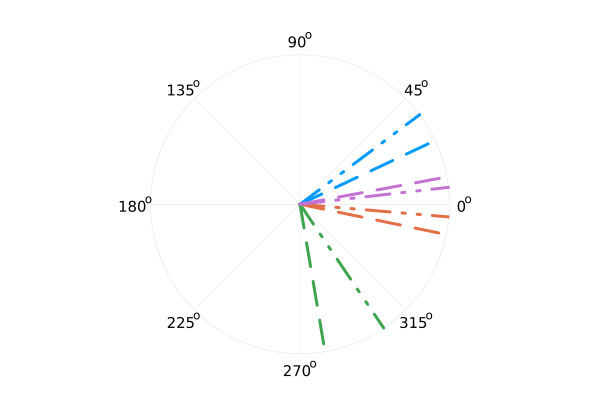

In [27]:
p5a = plot([theta_ACaS, theta_ACaS], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10, linestyle=:dash)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS, theta_CaTCaS], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd, theta_NaKd], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA, theta_CaTA], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p5a)
# savefig(p5a, "./figures/STG_MC_polar_DIC.pdf")

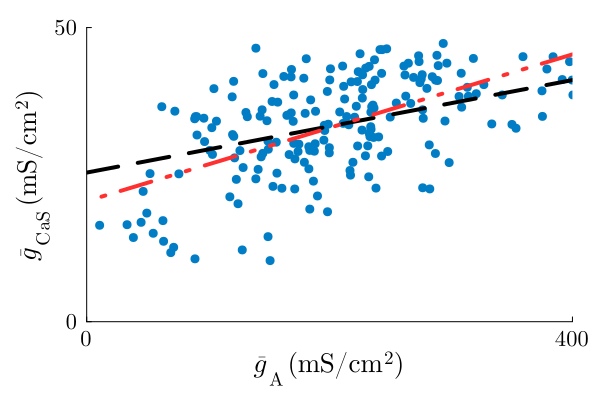

In [53]:
p5b = scatter(g_all_MC[:, 4], g_all_MC[:, 3], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, tickfontsize=15, yticks=([0, 50], [L"0", L"50"]),
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))

plot!([mean_MC[4] - 10*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4], 
      mean_MC[4] + 10*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4]],
      [mean_MC[3] - 10*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4], 
      mean_MC[3] + 10*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC[4] - 10000000* dgs_dCaS, mean_MC[4] + 10000000*dgs_dCaS],
      [mean_MC[3] + 10000000*dgs_dA, mean_MC[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p5b)
# savefig(p5b, "./figures/neuromod_gCaSA_MC_DIC.pdf")

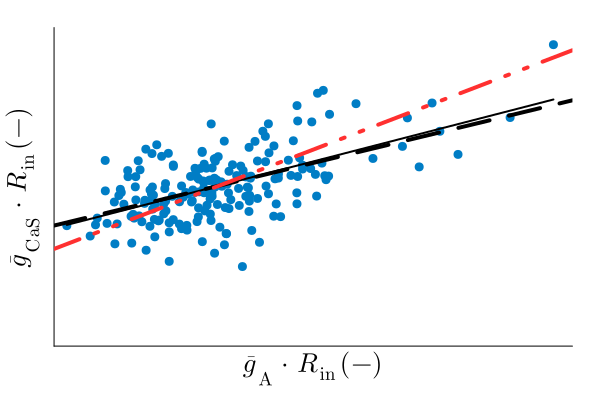

In [62]:
p5b = scatter(g_all_MC_normalized[:, 4], g_all_MC_normalized[:, 3], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, tickfontsize=15, yticks=false,
              xticks=false, size=(600, 400))
mean_MC_normalized = zeros(1, nb_channels)
mean!(mean_MC_normalized, g_all_MC_normalized)

line_normalized = fit(g_all_MC_normalized[:, 4], g_all_MC_normalized[:, 3], 1)
        s0 = minimum(g_all_MC_normalized[:, 4])
        sn = maximum(g_all_MC_normalized[:, 4])
        plot!([s0, sn], [line_normalized(s0), line_normalized(sn)], linewidth=2, label="", linecolor="black")

plot!([mean_MC_normalized[4] - 400*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4], 
      mean_MC_normalized[4] + 400*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4]],
      [mean_MC_normalized[3] - 400*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4], 
      mean_MC_normalized[3] + 400*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC_normalized[4] - 10000000* dgs_dCaS, mean_MC_normalized[4] + 10000000*dgs_dCaS],
      [mean_MC_normalized[3] + 10000000*dgs_dA, mean_MC_normalized[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaS}\cdot R_\mathrm{in}\,\mathrm{(-)}")
xlabel!(L"\bar{g}_\mathrm{A}\cdot R_\mathrm{in}\,\mathrm{(-)}")
ylims!((0, 800))
xlims!((0, 8000))
display(p5b)
# savefig(p5b, "./figures/neuromod_gCaSA_MC_DIC.pdf")

# **Uncovering that apparent correlation comes from two physiological mechanisms that can be interefering (Figure 6)**

In [29]:
g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")

# Definition of the number of cells in the random set
const ncells = 500;

In [30]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

# Normalizing data before applying PCA
g_all_bursting_norm = deepcopy(g_all_bursting)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting[:, i] / std(g_all_bursting[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] * std(g_all_bursting[:, i])
end

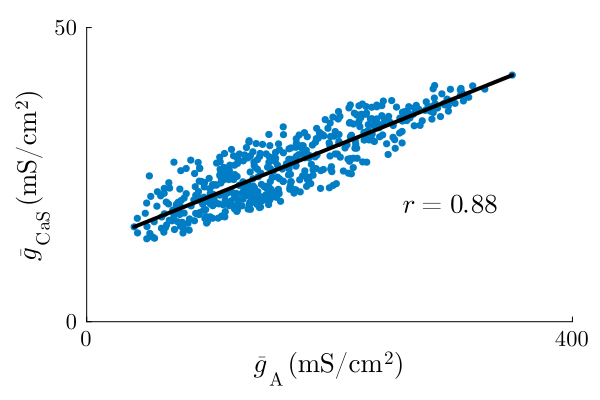

In [31]:
p6a = scatter(g_all_bursting[:, 4], g_all_bursting[:, 3], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([0, 50], [L"0", L"50"]), tickfontsize=15, 
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))

line_43 = fit(g_all_bursting[:, 4], g_all_bursting[:, 3], 1)
s0 = minimum(g_all_bursting[:, 4])
sn = maximum(g_all_bursting[:, 4])
plot!([s0, sn], [line_43(s0), line_43(sn)], linewidth=4, label="", linecolor="black")

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(300, 20, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p6a)
# savefig(p6a, "./figures/PCA_STG_neuromod_gCaSA_bursting.pdf")

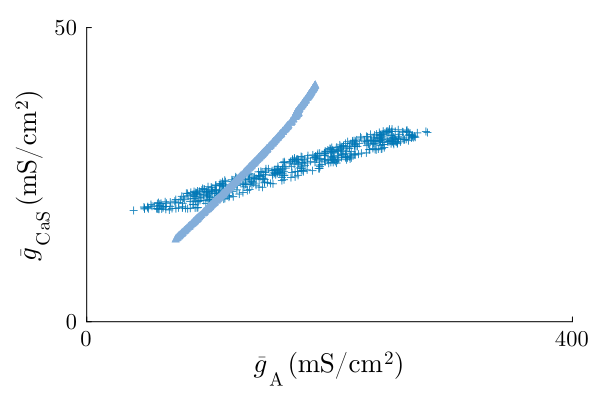

In [32]:
p6b = scatter(g_all_bursting_DIC[:, 4], g_all_bursting_DIC[:, 3], label="", 
              markershape=:cross, color=myDICBlue, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, legend=false, 
              yticks=([0, 50], [L"0", L"50"]), tickfontsize=15, 
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))
scatter!(g_all_bursting_leak[:, 4], g_all_bursting_leak[:, 3], label="", 
         color=myLeakBlue, markershape=:utriangle, markerstrokewidth=0.)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p6b)
# savefig(p6b, "./figures/neuromod_gCaSA_separation_bursting.pdf")

# **Correlations are neuromodulation dependent (Figure 7)**

In [33]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_doublets = readdlm("./data/g_all_doublets.dat")
g_all_doublets_DIC = readdlm("./data/g_all_doublets_DIC.dat")
g_all_doublets_leak = readdlm("./data/g_all_doublets_leak.dat")

burstiness_doublets = readdlm("./data/burstiness_doublets.dat")
burstiness_doublets_plot = readdlm("./data/burstiness_doublets_plot.dat")
burstiness_doublets_DIC = readdlm("./data/burstiness_doublets_DIC.dat")
burstiness_doublets_DIC_plot = readdlm("./data/burstiness_doublets_DIC_plot.dat")
burstiness_doublets_leak = readdlm("./data/burstiness_doublets_leak.dat")
burstiness_doublets_leak_plot = readdlm("./data/burstiness_doublets_leak_plot.dat")
burstiness_bursting = readdlm("./data/burstiness_bursting.dat")
burstiness_bursting_DIC = readdlm("./data/burstiness_bursting_DIC.dat")
burstiness_bursting_leak = readdlm("./data/burstiness_bursting_leak.dat");

In [34]:
# Defining colors for the color map
mySalmon = RGB{Float64}(243. / 255., 124. / 255., 130. / 255.)
myYellow = RGB{Float64}(253. / 255., 211. / 255., 44. / 255.)
mycmap = ColorScheme([mySalmon, myYellow]);

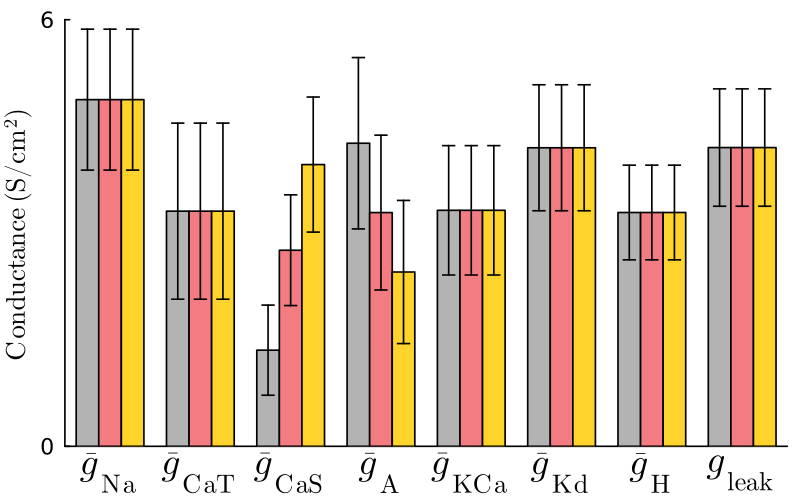

In [35]:
# Defining the number of conductances
nb_channels = 8

# Defining a matrix containing all conductances
g_all_bar = zeros(ncells, nb_channels*3)
scaling =  [1, 700, 150, 15, 30, 25, 9000, 400000]
g_all_spiking_bar = g_all_spiking ./ 1e3
g_all_doublets_bar = g_all_doublets ./ 1e3
g_all_bursting_bar = g_all_bursting ./ 1e3
for i = 1 : nb_channels
    g_all_bar[:, (i-1)*3 + 1] = g_all_spiking_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 2] = g_all_doublets_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 3] = g_all_bursting_bar[:, i] .* scaling[i]
end

p = bar([1:4:29], mean(g_all_bar[:, 1:3:22], dims=1)', label="", grid=false, yguidefontsize=18, 
          color=:gray70, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
          margin=3Plots.mm, yticks=[0, 6],  xrotation=0, xticks=false, 
          yerror=std(g_all_bar[:, 1:3:22], dims=1)', bar_width=1, ylabel=L"\mathrm{Conductance}\,\,\mathrm{(S/cm^2)}")

bar!([2:4:30], mean(g_all_bar[:, 2:3:23], dims=1)', label="", grid=false, yguidefontsize=18, 
    color=mySalmon, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
    margin=3Plots.mm, yticks=[0, 6],  xrotation=0, xticks=false, 
    yerror=std(g_all_bar[:, 2:3:23], dims=1)', bar_width=1)

bar!([3:4:31], mean(g_all_bar[:, 3:3:24], dims=1)', label="", grid=false, yguidefontsize=18, 
    color=myYellow, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, xtickfontsize=25,
    margin=3Plots.mm, yticks=[0, 6],  xrotation=0, yerror=std(g_all_bar[:, 3:3:24], dims=1)', 
    bar_width=1, xticks=(2:4:30, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
                                  L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
                                  L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]))

xlims!((0., 32.))
ylims!((0, 6))

p7a = plot(p, layout=(1, 1), legend=false, size=(807,500, 300))
display(p7a)
# savefig(p7a, "./figures/neuromod_gCaSA_gbar.pdf")

In [36]:
# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking)

# Means on triplets point cloud
mean_doublets = zeros(1, nb_channels)
mean!(mean_doublets, g_all_doublets)

# Defining scaling factors for the plots
s1 = 1.3
s2 = 2.2

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking[:, i] / std(g_all_spiking[:, i])
end

g_all_doublets_norm = deepcopy(g_all_doublets)
for i = 1 : nb_channels
    g_all_doublets_norm[:, i] = g_all_doublets[:, i] / std(g_all_doublets[:, i])
end

# PCA on triplets point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# PCA on doublets point cloud
cov_matrix_doublets = cov(g_all_doublets_norm)
eig_doublets = eigen(cov_matrix_doublets, sortby = x -> abs(x))

eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] * std(g_all_spiking[:, i])
end

eig_doublets_plot = deepcopy(eig_doublets)
for i = 1 : nb_channels
    eig_doublets_plot.vectors[i, :] = eig_doublets_plot.vectors[i, :] * std(g_all_doublets[:, i])
end

In [37]:
# Initializing a flag
flag_start = true

# Removing unsuccessful simulations
for i = 1 : ncells
    if !isnan.(burstiness_doublets_plot)[i]
        if flag_start
            # Creating the conductance matrix
            global g_all_doublets_plot = g_all_doublets[i, :]
            flag_start = false
        else
            # Adding a line to the conductance matrix
            g_all_doublets_plot = hcat(g_all_doublets_plot, g_all_doublets[i, :])
        end
    end
end

# Transposing the conductance matrix
if @isdefined g_all_doublets_plot
    g_all_doublets_plot = g_all_doublets_plot'
end;

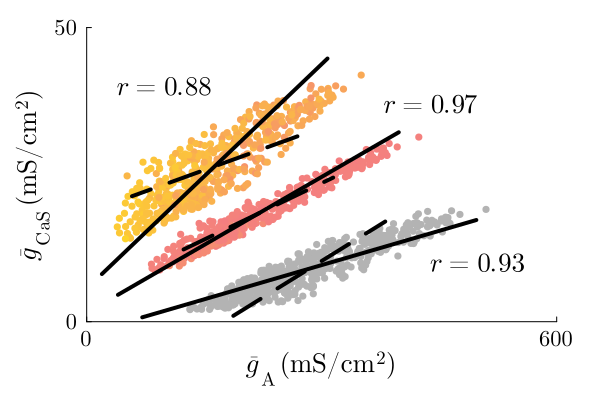

In [38]:
s2 = 2.3
p7b = scatter(g_all_spiking[:, 4], g_all_spiking[:, 3], label="", grid=false, yguidefontsize=18, xguidefontsize=18, 
              margin=5Plots.mm, legend=false, color=:gray70, colorbar_title="burstiness", tickfontsize=15,
              colorbar_titlefontsize=18, markerstrokewidth=0., size=(600, 400), 
              xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]))
scatter!(g_all_doublets_plot[:, 4], g_all_doublets_plot[:, 3], label="", 
         zcolor=burstiness_doublets, c=cgrad(mycmap, rev=false), markerstrokewidth=0.)
scatter!(g_all_bursting[:, 4], g_all_bursting[:, 3], label="", 
         zcolor=burstiness_bursting, c=cgrad(mycmap, rev=false),
         markerstrokewidth=0.)

plot!([mean_spiking[4] - s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[4] + s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels]],
       [mean_spiking[3] - s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[3] + s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_spiking[4] - s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[4] + s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1]],
       [mean_spiking[3] - s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[3] + s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_doublets[4] - s1*eig_doublets_plot.vectors[:, nb_channels][4]*eig_doublets_plot.values[nb_channels], 
       mean_doublets[4] + s1*eig_doublets_plot.vectors[:, nb_channels][4]*eig_doublets_plot.values[nb_channels]],
       [mean_doublets[3] - s1*eig_doublets_plot.vectors[:, nb_channels][3]*eig_doublets_plot.values[nb_channels], 
       mean_doublets[3] + s1*eig_doublets_plot.vectors[:, nb_channels][3]*eig_doublets_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_doublets[4] - s2*eig_doublets_plot.vectors[:, nb_channels-1][4]*eig_doublets_plot.values[nb_channels-1], 
       mean_doublets[4] + s2*eig_doublets_plot.vectors[:, nb_channels-1][4]*eig_doublets_plot.values[nb_channels-1]],
       [mean_doublets[3] - s2*eig_doublets_plot.vectors[:, nb_channels-1][3]*eig_doublets_plot.values[nb_channels-1], 
       mean_doublets[3] + s2*eig_doublets_plot.vectors[:, nb_channels-1][3]*eig_doublets_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_bursting[4] - s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[4] + s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels]],
       [mean_bursting[3] - s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[3] + s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_bursting[4] - s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[4] + s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1]],
       [mean_bursting[3] - s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[3] + s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(500, 10, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

pearson_cor_doublets = cor(g_all_doublets[:, 3], g_all_doublets[:, 4])
str_pearson_cor_doublets = @sprintf "%.2f" pearson_cor_doublets
annotate!(440, 37, Plots.text(L"r =  %$str_pearson_cor_doublets", :black, :center, 18))

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(100, 40, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p7b)
# savefig(p7b, "./figures/PCA_STG_neuromod_gCaSA_burstiness.pdf")

In [39]:
# Initializing a flag
flag_start = true

# Removing unsuccessful simulations
for i = 1 : ncells
    if !isnan.(burstiness_doublets_DIC_plot)[i]
        if flag_start
            # Creating the conductance matrix
            global g_all_doublets_DIC_plot = g_all_doublets_DIC[i, :]
            flag_start = false
        else
            # Adding a line to the conductance matrix
            g_all_doublets_DIC_plot = hcat(g_all_doublets_DIC_plot, g_all_doublets_DIC[i, :])
        end
    end
end

# Transposing the conductance matrix
if @isdefined g_all_doublets_DIC_plot
    g_all_doublets_DIC_plot = g_all_doublets_DIC_plot'
end;

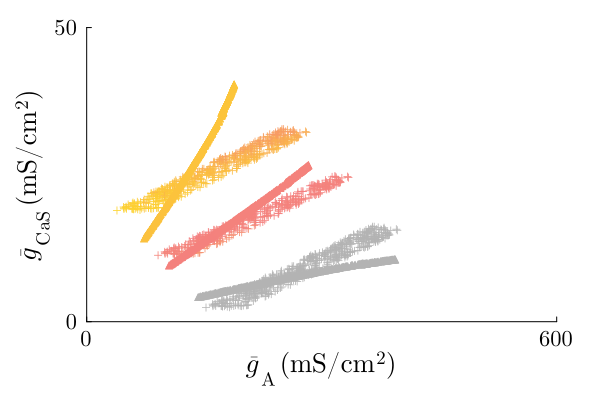

In [40]:
p7c = scatter(g_all_spiking_DIC[:, 4], g_all_spiking_DIC[:, 3], label="", legend=false,
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, tickfontsize=15,
              colorbar_titlefontsize=18, size=(600, 400), 
              xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]),
              colorbar_title="burstiness")
scatter!(g_all_spiking_leak[:, 4], g_all_spiking_leak[:, 3], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)
scatter!(g_all_doublets_DIC_plot[:, 4], g_all_doublets_DIC_plot[:, 3], label="", markershape=:cross,
         zcolor=burstiness_doublets_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_doublets_leak[:, 4], g_all_doublets_leak[:, 3], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_doublets_leak, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_DIC[:, 4], g_all_bursting_DIC[:, 3], label="",
         markershape=:cross, zcolor=burstiness_bursting_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_leak[:, 4], g_all_bursting_leak[:, 3], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_bursting_leak, c=cgrad(mycmap, rev=false))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p7c)
# savefig(p7c, "./figures/neuromod_gCaSA_separation_burstiness.pdf")

# **Neuromodulation paths can arise from simple rule, but not as simple as purely additive or multiplicative (Figure 8)**

In [41]:
burstiness = readdlm("./data/burstiness_paths.dat")
g_all_init = readdlm("./data/g_all_init_paths.dat")
gCaSs = readdlm("./data/gCaSs_paths.dat")
gAs = readdlm("./data/gAs_paths.dat");

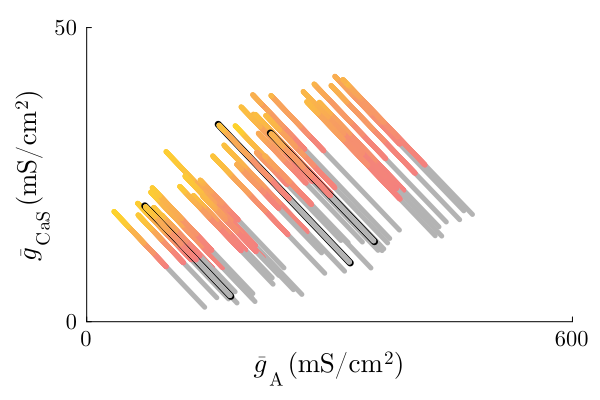

In [42]:
#### Initializing some variables
n = size(gCaSs)[2]

# Picking first path randomly
Random.seed!(2020)
j1 = Int(ceil(rand(1, 1)[1] * n))

# Picking second path randomly
Random.seed!(410)
j2 = Int(ceil(rand(1, 1)[1] * n))

# Picking third path randomly
Random.seed!(809)
j3 = Int(ceil(rand(1, 1)[1] * n))

# Plotting the results
p8a = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
           xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]))

# Looping over all neurons
for j = 1 : n    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gAs[1:i_thresh, j], gCaSs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gAs[i_thresh:end, j], gCaSs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(700, 7000),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

# Plotting special paths
for j in [j1, j2, j3]
    # Add a black frame to the path
    line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
    start_x = minimum(gAs[:, j]) - 1
    end_x = maximum(gAs[:, j]) + 1
    plot!([start_x, end_x], [line_ACaS(start_x), line_ACaS(end_x)], 
          label="", grid=false, linewidth=7, yguidefontsize=18, 
          xguidefontsize=18, margin=5Plots.mm, color=:black)

    plot!(gAs[:, j], gCaSs[:, j], label="", grid=false, linewidth=5, 
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:white)
    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gAs[1:i_thresh, j], gCaSs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gAs[i_thresh:end, j], gCaSs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(700, 7000),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p8a)
# savefig(p8a, "./figures/neuromod_gCaSA_paths.pdf")

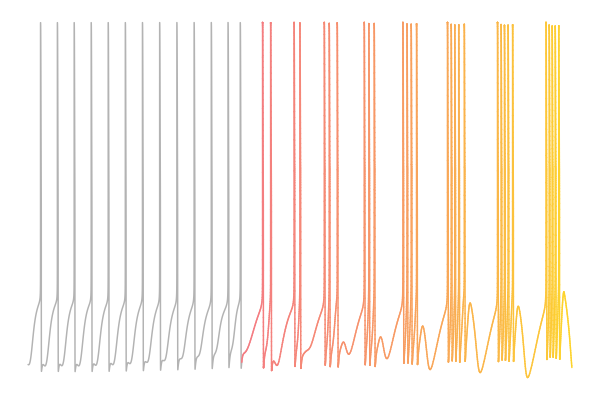

In [43]:
# Definition of simulation time (in ms)
const Tfinal = 2015
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(2020)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1090:end]
t = sol.t[1090:end]
p8b = plot(t[1:2110], V_t[1:2110], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[2110:end], V_t[2110:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[2110:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8b)
# savefig(p8b, "./figures/neuromod_gCaSA_path_simu1.pdf")

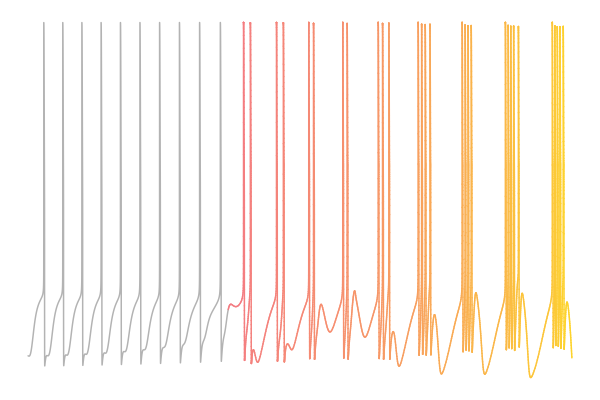

In [44]:
# Definition of simulation time (in ms)
const Tfinal = 2050
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(410)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1130:end]
t = sol.t[1130:end]
p8c = plot(t[1:1700], V_t[1:1700], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[1700:end], V_t[1700:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[1700:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8c)
# savefig(p8c, "./figures/neuromod_gCaSA_path_simu2.pdf")

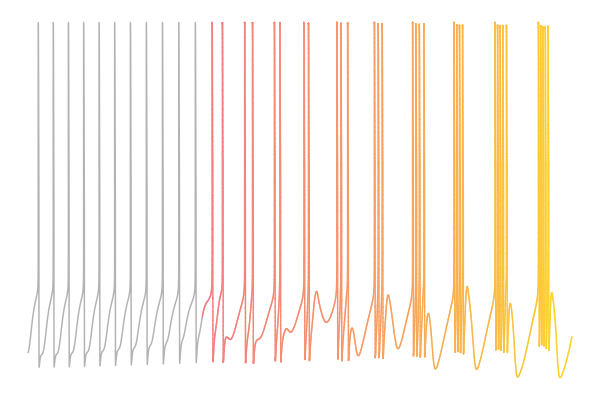

In [45]:
# Definition of simulation time (in ms)
const Tfinal = 2080
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(809)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1080:end]
t = sol.t[1080:end]
p8d = plot(t[1:1765], V_t[1:1765], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[1765:end], V_t[1765:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[1765:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8d)
# savefig(p8d, "./figures/neuromod_gCaSA_path_simu3.pdf")

# **Supplementary figures**

## **Figure S1**

In [46]:
## Verifying robustness of the neuromodulated bursting sets
# Initializing variables
burstiness = zeros(ncells)
nb_spikes = zeros(ncells)
intraburst_f = zeros(ncells)
interburst_f = zeros(ncells)

# Loop over all neurons in the set
@showprogress 1 "Computing..." for i = 1 : ncells
  # Extracting the maximal ion channel conductances
  (gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_bursting[i, :]

  # Parameter vector for simulations
  p = [0., gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak, C]

  # Initial conditions
  V0  = -70.
  Ca0 = 0.5
  x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
        hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]
    
  # Simulation
  prob = ODEProblem(STG_ODE, x0, tspan, p)
  sol = solve(prob, saveat=0.1, verbose=false)

  # Removing transient part
  V_t = sol[1, :][5001 : end]
  t = sol.t[5001 : end]
    
  # Computing the burstiness and burst characteristics of the firing pattern
  (burstiness[i], nb_spikes[i], intraburst_f[i], 
        interburst_f[i]) = extract_burstiness(V_t, t)
end

Computing... 100%|███████████████████████████████████████| Time: 0:01:07


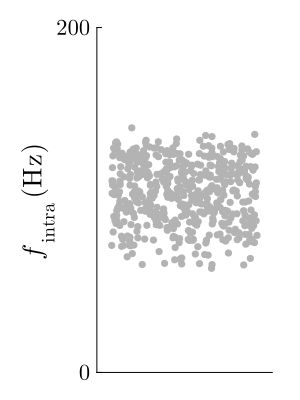

In [47]:
Random.seed!(2022)
pSa = scatter(rand(ncells), intraburst_f, label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([0, 200], [L"0", L"200"]), tickfontsize=15, 
              xticks=false, size=(300, 400))

ylabel!(L"f_\mathrm{intra}\,\mathrm{(Hz)}")
xlims!((-0.1, 1.1))
ylims!((0, 200))
display(pSa)
# savefig(pSa, "./figures/STG_intraburst_freq_bursting.pdf")

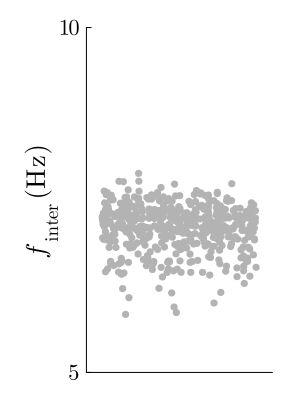

In [48]:
Random.seed!(2022)
full_T = 1 ./ interburst_f + ((nb_spikes.-1) ./ intraburst_f)
pSb = scatter(rand(ncells), 1 ./ full_T, label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([5, 10], [L"5", L"10"]), tickfontsize=15, 
              xticks=false, size=(300, 400))

ylabel!(L"f_\mathrm{inter}\,\mathrm{(Hz)}")
xlims!((-0.1, 1.1))
ylims!((5, 10))
display(pSb)
# savefig(pSb, "./figures/STG_interburst_freq_bursting.pdf")

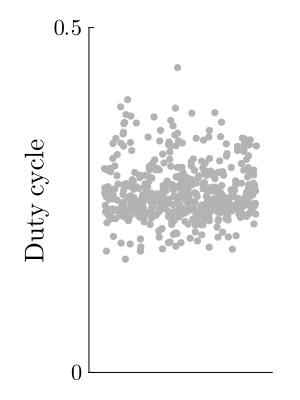

In [49]:
full_T = 1 ./ interburst_f + ((nb_spikes.-1) ./ intraburst_f)
duty_cycle = ((nb_spikes.-1) ./ intraburst_f) ./ full_T
Random.seed!(2022)
pSc = scatter(rand(ncells), duty_cycle, label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., tickfontsize=15, yticks=([0, 0.5], [L"0", L"0.5"]), 
              xticks=false, size=(300, 400))

ylabel!(L"\mathrm{Duty}\,\, \mathrm{cycle}")
xlims!((-0.1, 1.1))
ylims!((0, 0.5))
display(pSc)
# savefig(pSc, "./figures/STG_duty_bursting.pdf")